# Category Prediction

Using the trained DinoV2Classification model for inference and evaluation.

## Prediction Use Cases

- **Single Prediction**: Make predictions on individual test samples with confidence scores
- **Top-K Predictions**: Display top-5 most likely categories with probabilities
- **Batch Prediction**: Efficiently predict on multiple samples at once

In [1]:
import os
import sys
from pathlib import Path

from dotenv import load_dotenv

notebooks_dir = Path().absolute()
project_dir = notebooks_dir.parent
os.chdir(project_dir)
load_dotenv()
sys.path.append(project_dir)

In [ ]:
import matplotlib.pyplot as plt
import torch

from marketplace.dataset import MarketplaceDataModule

In [ ]:
dm = MarketplaceDataModule(batch_size=32)
dm.setup(stage="test")

### Category Prediction

Load a trained model from checkpoint and make predictions on test samples.

In [15]:
import warnings

from marketplace.const import IMAGENET_MEAN, IMAGENET_STD
from marketplace.model import DinoV2Classification

warnings.filterwarnings("ignore", message="xFormers is available")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load model from checkpoint
checkpoint_path = "checkpoints/dinov2-classification-20251220-1723.ckpt"

model = DinoV2Classification.load_from_checkpoint(checkpoint_path)
model.eval()
model = model.to(device)

print(f"Model loaded from: {checkpoint_path}\nModel hyperparameters:")
print(f"  - Learning rate: {model.hparams.learning_rate}")
print(f"  - Number of classes: {model.hparams.num_classes}")
print(f"  - MLP head: {model.hparams.mlp}")

Model loaded from: checkpoints/dinov2-classification-20251220-1723.ckpt
Model hyperparameters:
  - Learning rate: 0.001
  - Number of classes: 223
  - MLP head: False


## Single Prediction Example

In [19]:
# Get a test sample
test_index = torch.randint(len(dm.test_dataset), (1,)).item()

image_tensor, true_label = dm.test_dataset[test_index]
image_tensor_batch = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

# Get class names
class_names = dm.train_dataset.dataset.classes

# Make prediction
with torch.no_grad():
    logits = model(image_tensor_batch)
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0, predicted_class].item()

# Display results
print(f"Test sample index: {test_index}")
print(f"True label: {class_names[true_label]}")
print(f"Predicted: {class_names[predicted_class]}")
print(f"Confidence: {confidence:.2%}")
print(f"Correct: {predicted_class == true_label}")

Test sample index: 3785
True label: building and construction material
Predicted: building and construction material
Confidence: 82.67%
Correct: True


## Visualize Prediction

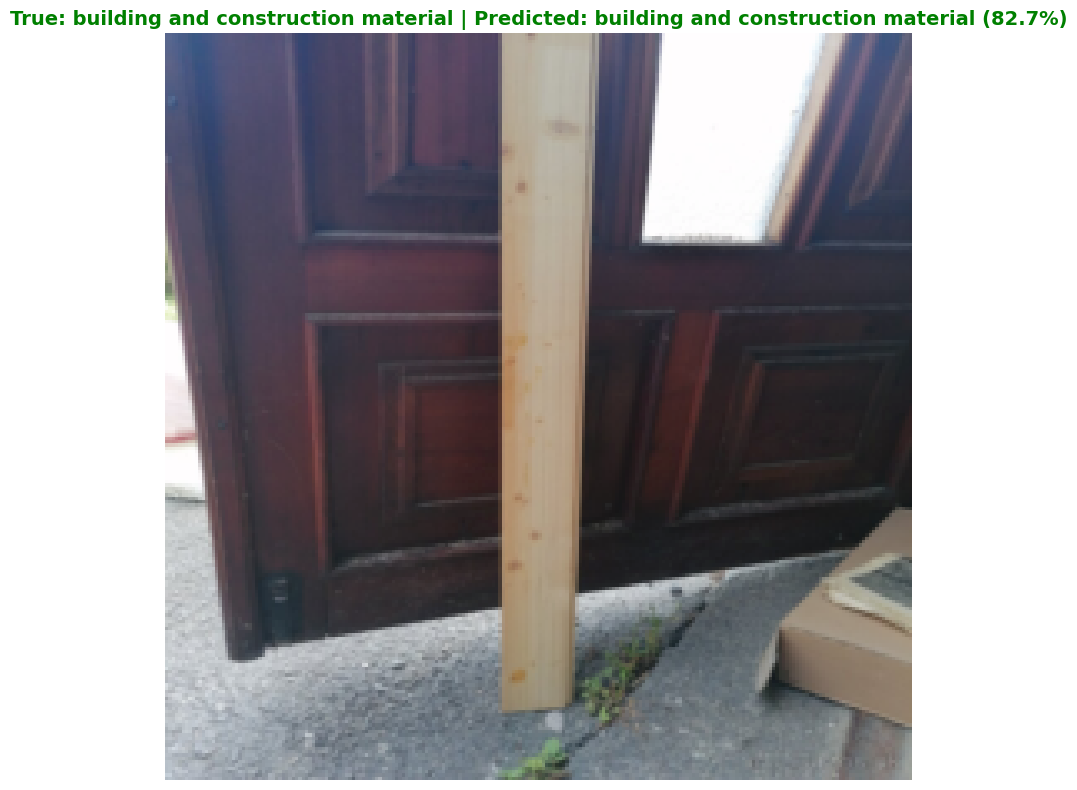

In [20]:
# Denormalize image for display
img = image_tensor.cpu()
img = img * torch.tensor(IMAGENET_STD).view(3, 1, 1) + torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
img = img.permute(1, 2, 0).numpy().clip(0, 1)

# Display image with prediction
plt.figure(figsize=(8, 8))
plt.imshow(img)

# Color-code the title: green if correct, red if incorrect
title_color = "green" if predicted_class == true_label else "red"
plt.title(
    f"True: {class_names[true_label]} | Predicted: {class_names[predicted_class]} ({confidence:.1%})",
    fontsize=14,
    color=title_color,
    weight="bold"
)
plt.axis("off")
plt.tight_layout()
plt.show()

## Top-5 Predictions

In [21]:
# Show top-5 predictions with probabilities
num_classes = len(class_names)
k = min(5, num_classes)  # Handle cases with fewer than 5 classes
top_k_probs, top_k_indices = torch.topk(probabilities[0], k=k)

print(f"Top-{k} predictions:")
print("-" * 50)
for i, (prob, idx) in enumerate(zip(top_k_probs, top_k_indices), 1):
    idx = idx.item()
    prob = prob.item()
    
    # Mark the true label with a star
    marker = "★" if idx == true_label else " "
    
    # Create a simple bar visualization
    bar_length = int(prob * 30)
    bar = "█" * bar_length
    
    print(f"{marker} {i}. {class_names[idx]:20s} {bar} {prob:6.2%}")

Top-5 predictions:
--------------------------------------------------
★ 1. building and construction material ████████████████████████ 82.67%
  2. antique pictures       3.16%
  3. home lighting          1.06%
  4. garden                 0.89%
  5. home furniture         0.88%


## Batch Prediction

Predict on multiple test samples at once.

In [22]:
def predict_batch(model, data_module, indices, device):
    """
    Make predictions on multiple test samples.
    
    Args:
        model: Trained DinoV2Classification model
        data_module: MarketplaceDataModule with setup test_dataset
        indices: List of indices to predict
        device: torch device (cuda/cpu)
    
    Returns:
        List of dicts with prediction results
    """
    model.eval()
    results = []
    class_names = data_module.train_dataset.dataset.classes

    for idx in indices:
        image_tensor, true_label = data_module.test_dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(image_tensor)
            probabilities = torch.softmax(logits, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        results.append({
            "index": idx,
            "true_label": true_label,
            "true_class": class_names[true_label],
            "predicted_class_idx": predicted_class,
            "predicted_class": class_names[predicted_class],
            "confidence": confidence,
            "correct": predicted_class == true_label,
        })

    return results

In [15]:
# Predict on first 10 test samples
batch_indices = torch.randint(len(dm.test_dataset), (10,)).tolist()
batch_results = predict_batch(model, dm, batch_indices, device)

# Display results
print("Batch Prediction Results:")
print("=" * 80)
for result in batch_results:
    status = "✓" if result["correct"] else "✗"
    print(
        f"{status} [{result['index']:3d}] "
        f"True: {result['true_class']:20s} | "
        f"Pred: {result['predicted_class']:20s} "
        f"({result['confidence']:.1%})"
    )

# Calculate accuracy
correct = sum(1 for r in batch_results if r["correct"])
total = len(batch_results)
accuracy = correct / total
print("\n" + "=" * 80)
print(f"Accuracy: {correct}/{total} = {accuracy:.1%}")

Batch Prediction Results:
✓ [12153] True: misc motherhood      | Pred: misc motherhood      (97.0%)
✓ [18666] True: sports bags          | Pred: sports bags          (46.8%)
✓ [11376] True: ice hockey other     | Pred: ice hockey other     (85.6%)
✓ [ 32] True: adults handicrafts   | Pred: adults handicrafts   (90.2%)
✓ [14910] True: prams                | Pred: prams                (97.8%)
✓ [16038] True: scooter              | Pred: scooter              (96.0%)
✗ [449] True: adults misc          | Pred: hunting              (31.6%)
✓ [19704] True: toys                 | Pred: toys                 (88.2%)
✓ [8713] True: hiking baby carries  | Pred: hiking baby carries  (97.2%)
✓ [14323] True: pc gaming            | Pred: pc gaming            (99.2%)

Accuracy: 9/10 = 90.0%


## Visualize Multiple Predictions

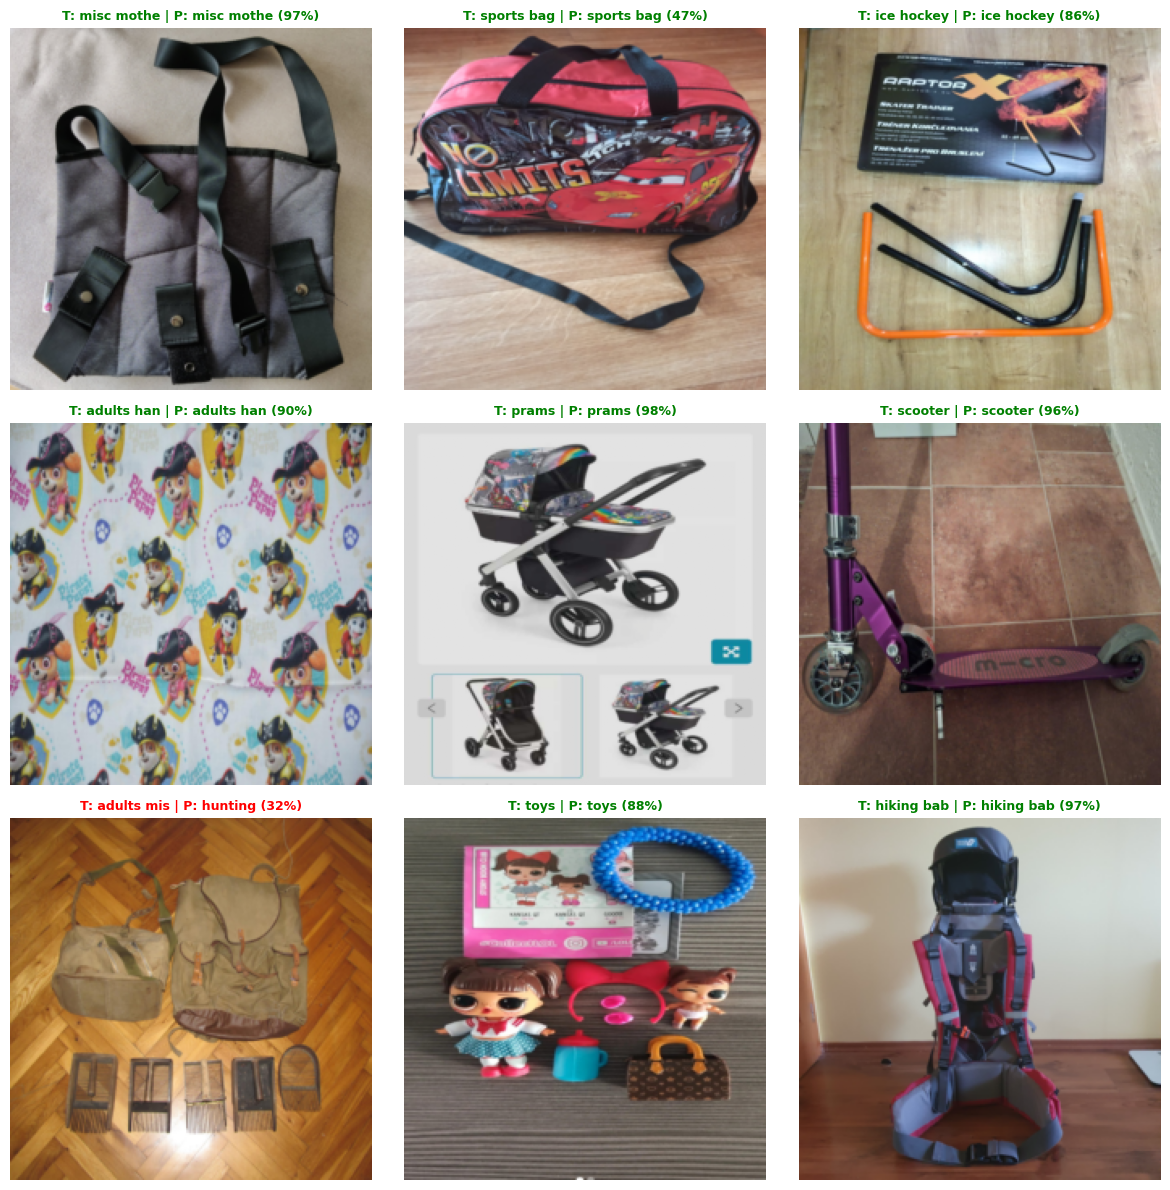

In [18]:
# Visualize a grid of predictions
num_samples = 9  # 3x3 grid
indices_to_show = batch_indices[:9]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, idx in enumerate(indices_to_show):
    image_tensor, true_label = dm.test_dataset[idx]
    image_tensor_batch = image_tensor.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        logits = model(image_tensor_batch)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
    
    # Denormalize image
    img = image_tensor.cpu()
    img = img * torch.tensor(IMAGENET_STD).view(3, 1, 1) + torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy().clip(0, 1)
    
    # Display
    axes[i].imshow(img)
    title_color = "green" if predicted_class == true_label else "red"
    axes[i].set_title(
        f"T: {class_names[true_label][:10]} | P: {class_names[predicted_class][:10]} ({confidence:.0%})",
        fontsize=9,
        color=title_color,
        weight="bold"
    )
    axes[i].axis("off")

plt.tight_layout()
plt.show()